In [1]:
print("hello world!")

hello world!


In [2]:
import numpy
import catboost
print(numpy.__version__)
print(catboost.__version__)

1.26.4
1.2.7


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import Pool, CatBoostRegressor

In [5]:
train = pd.read_parquet('train_main.parquet')
test = pd.read_parquet('test_main.parquet')

In [6]:
print('Данные для обучения:', train.shape)
print('Тестовые данные:', test.shape)

Данные для обучения: (213345, 280)
Тестовые данные: (318451, 280)


In [7]:
train.head(n = 5)

,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027.373535,...,34.613216,0.000000,4.310414,75.214180,Массовый,0,0,1,0,0
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.237672,0.000000,0.000000,0.000000,Массовый,0,0,1,0,0
2,12,0.0,0.0,0.0,105372.960938,0.0,0.0,315208.781250,NaN,274816.375000,...,0.000000,53.134129,90.025238,0.000000,Массовый,0,0,1,0,0
3,13,1.0,0.0,3.0,0.000000,0.0,0.0,43187.953125,NaN,5277.233887,...,0.000000,22.276114,82.070015,117.386795,Массовый,0,0,1,0,0
4,15,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,33.072178,Массовый,0,0,1,0,0


In [8]:
missing_values = train.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]
print('\nColumns with missing values:\n', missing_values)


Columns with missing values:
 vehicle_counrty_type_nm    206739
max_amt_foreign_cur_5y     201136
max_amt_dep_6m             182526
min_amt_term_g1y           180330
max_amt_dep_act            175074
                            ...  
cnt_foreign_cur_5y             26
cnt_save_5y                    26
cnt_grow_5y                    26
cnt_term_g1y                   26
cnt_manage_5y                  26
Length: 167, dtype: int64


In [9]:
train.dtypes.value_counts()

float64    266
object       8
int32        6
Name: count, dtype: int64

In [10]:
features = train.columns

categorical_features = train[features].select_dtypes(include=['object']).columns

for feature in categorical_features:
    train[feature] = train[feature].astype(str)

categorical_features_indices = np.where(train.dtypes == 'object')[0]

In [11]:
target = pd.read_csv('train_target.csv')
target.shape

(213345, 2)

In [12]:
target.head(5)

,user_id,target
0,9,0.00000
1,11,0.00000
2,12,219932.90625
3,13,631.77002
4,15,0.00000


In [13]:
target['target'].describe()

count    2.133450e+05
mean     2.210490e+05
std      9.894988e+05
min     -7.100000e-01
25%      0.000000e+00
50%      3.174000e+01
75%      1.000027e+05
max      1.015605e+08
Name: target, dtype: float64

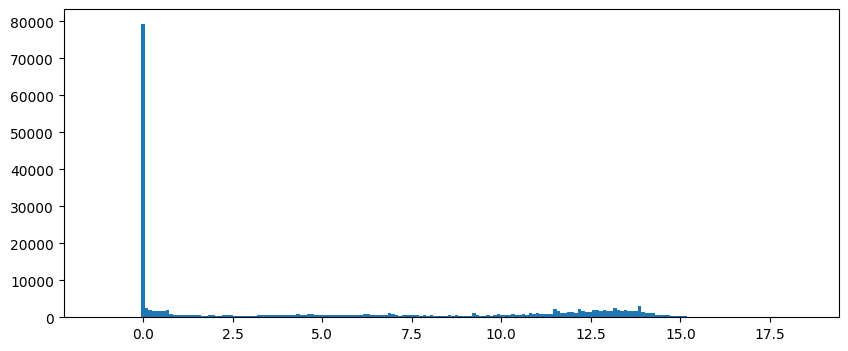

In [14]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(target['target']), bins = 200);

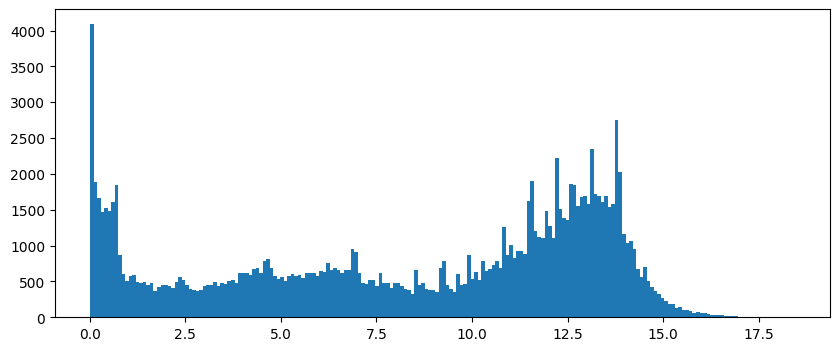

In [15]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(target.loc[target['target'] > 0, 'target']), bins = 200);

In [16]:
train_pool = Pool(data = train,
                    label = np.log1p(target['target']),
                    cat_features = categorical_features_indices)

In [ ]:
model = CatBoostRegressor(
    iterations=100,
    depth=8,
    learning_rate=0.05,
    loss_function='RMSE',
    nan_mode='Max',
    random_seed=314,
    verbose=10,
    l2_leaf_reg=5,
    bootstrap_type='Bernoulli',  
    subsample=0.8,  # Теперь поддерживается
    grow_policy='Lossguide',
    od_type='Iter',
    od_wait=10
)


In [33]:
model.fit(train_pool)

0:	learn: 5.3465598	total: 884ms	remaining: 1m 27s
99:	learn: 1.9911150	total: 1m 32s	remaining: 0us


In [19]:
sample = pd.read_csv('sample_submit_naive.csv')
sample.shape

(318451, 2)

In [20]:
sample.head(5)

,user_id,predict
0,1000008,1.004656e+06
1,1000009,0.000000e+00
2,1000013,5.047758e+02
3,1000016,1.680799e+05
4,1000017,2.222542e+02


In [21]:
test.head(5)

,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,1000008,NaN,NaN,NaN,NaN,NaN,NaN,998138.562500,2678.699219,1.009246e+06,...,0.000000,0.000000,67.893509,0.000000,Массовый,0,0,1,0,0
1,1000009,0.0,NaN,NaN,29125.394531,0.0,0.0,0.000030,NaN,NaN,...,8.407050,54.111416,70.213890,82.739632,Массовый,0,0,1,0,0
2,1000013,0.0,0.0,0.0,59536.816406,0.0,0.0,54086.031250,NaN,3.513455e+04,...,0.000000,0.000000,0.000000,56.554066,Массовый,0,0,1,0,0
3,1000016,0.0,NaN,NaN,66908.468750,0.0,0.0,60340.105469,NaN,6.347482e+04,...,33.321732,59.461399,0.000000,0.000000,Массовый,0,0,1,1,0
4,1000017,NaN,NaN,NaN,NaN,NaN,NaN,0.000030,NaN,0.000000e+00,...,26.527195,0.000000,56.962830,59.217648,Массовый,0,0,1,0,0


In [22]:
test_pool = Pool(data = test,
                 cat_features = categorical_features_indices)

In [23]:
test_predict = model.predict(test_pool)
test_predict.shape

(318451,)

In [24]:
test_full_predict = np.exp(test_predict) - 1

In [25]:
sample['predict'] = test_full_predict

In [26]:
sample.head(5)

,user_id,predict
0,1000008,67807.784738
1,1000009,0.116805
2,1000013,11.701968
3,1000016,141.802913
4,1000017,9.016016


In [27]:
sample.to_csv('submit_baseline_catboost.csv', index=False)